In [1]:
from PLSR_class import PLSRModel
import sys
sys.path.append('../baseline_for_training')
sys.path.append('../.')
from Dataset import Dataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_file_name = 'train_data.parquet'
validation_file_name = 'validation_data.parquet'
test_file_name = 'test_data.parquet'
dataset = Dataset(train_file_name,validation_file_name,test_file_name)

# Dependent Features Correlations

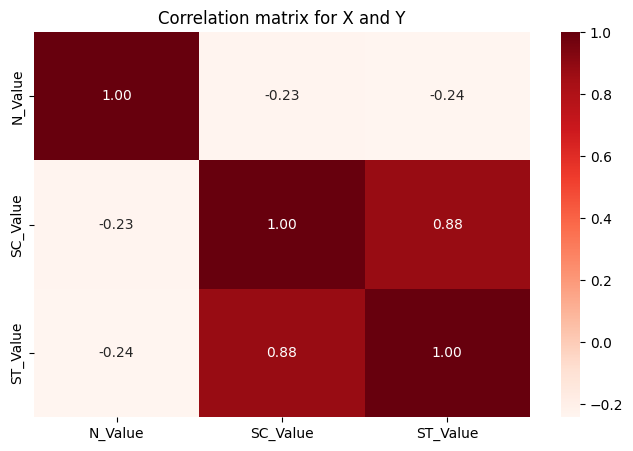

In [3]:
plt.figure(figsize=(8,5))
sns.heatmap(pd.concat([dataset.Y_train, dataset.Y_val,dataset.Y_test],axis=0).corr(),annot=True,fmt=".2f",cmap='Reds')
plt.title('Correlation matrix for X and Y')
plt.savefig('correlation_matrix.png')
plt.show()

<Figure size 800x500 with 0 Axes>

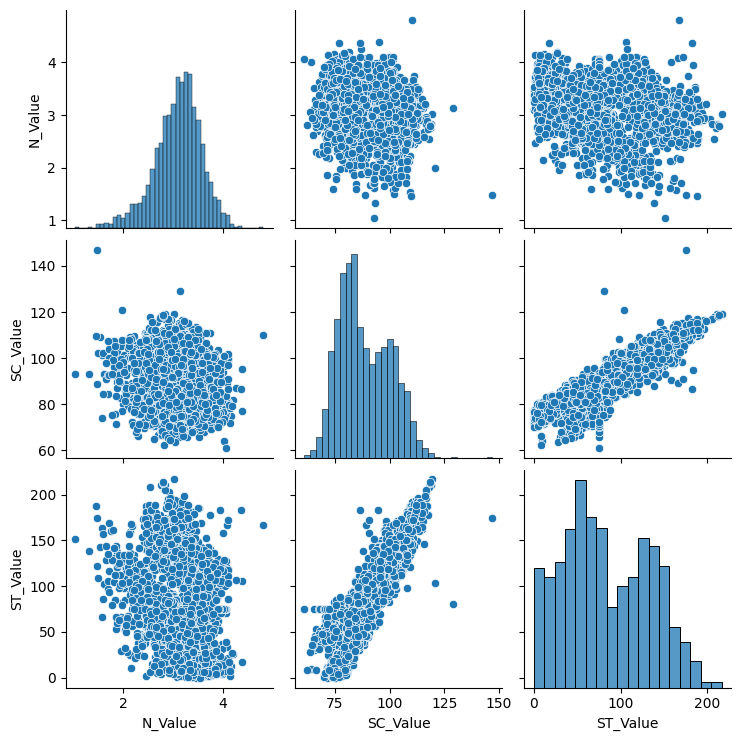

In [4]:
# Pairplot for Y
plt.figure(figsize=(8,5))
sns.pairplot(pd.concat([dataset.Y_train, dataset.Y_val,dataset.Y_test],axis=0))
plt.show()

# Preprocessing

In [5]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()

dataset.X_train[dataset.X_train.columns] = X_scaler.fit_transform(dataset.X_train.values)
dataset.Y_train[dataset.Y_train.columns] = Y_scaler.fit_transform(dataset.Y_train.values)

dataset.X_val[dataset.X_val.columns] = X_scaler.transform(dataset.X_val.values)
dataset.Y_val[dataset.Y_val.columns] = Y_scaler.transform(dataset.Y_val.values)

dataset.X_test[dataset.X_test.columns] = X_scaler.transform(dataset.X_test.values)
dataset.Y_test[dataset.Y_test.columns] = Y_scaler.transform(dataset.Y_test.values)

In [6]:
# Flags for the PLSR model
is_multi_output = True
PLSR_Tuning = True

# Define the parameter grid
param_grid = {'n_components': [i for i in range(1,51)]}

# Create the PLSR models
multi_PLSR = PLSRModel(dataset, param_grid, is_multi_output)
n_value_PLSR = PLSRModel(dataset, param_grid, not is_multi_output, "N_Value")
sc_value_PLSR = PLSRModel(dataset, param_grid, not is_multi_output, "SC_Value")
st_value_PLSR = PLSRModel(dataset, param_grid, not is_multi_output, "ST_Value")

# Tuning Number of Components

In [7]:
from Training_and_Tuning import hyperParameterTuning

In [8]:
# Perform hyperparameter tuning
multi_rmses = hyperParameterTuning(multi_PLSR,PLSR_Tuning = PLSR_Tuning)
n_value_rmses = hyperParameterTuning(n_value_PLSR,PLSR_Tuning = PLSR_Tuning)
sc_value_rmses = hyperParameterTuning(sc_value_PLSR,PLSR_Tuning = PLSR_Tuning)
st_value_rmses = hyperParameterTuning(st_value_PLSR,PLSR_Tuning = PLSR_Tuning)

Optimizing Number of Components:  90%|█████████ | 45/50 [00:12<00:01,  3.52it/s]


KeyboardInterrupt: 

In [110]:
best_n_components = sorted(multi_rmses['Avg_RMSE'], key = lambda x:x[1])[0][0]['n_components']
print('Best Multi Output PLSR Number of Components:', best_n_components)

Best Multi Output PLSR Number of Components: 26


In [111]:
best_n_value_n_components = sorted(n_value_rmses['N_Value'], key = lambda x:x[1])[0][0]['n_components']
print('Best N Value PLSR Number of Components:', best_n_value_n_components)

Best N Value PLSR Number of Components: 26


In [112]:
best_sc_value_n_components = sorted(sc_value_rmses['SC_Value'], key = lambda x:x[1])[0][0]['n_components']
print('Best SC Value PLSR Number of Components:', best_sc_value_n_components)

Best SC Value PLSR Number of Components: 27


In [113]:
best_st_value_n_components = sorted(st_value_rmses['ST_Value'], key = lambda x:x[1])[0][0]['n_components']
print('Best ST Value PLSR Number of Components:', best_st_value_n_components)

Best ST Value PLSR Number of Components: 17


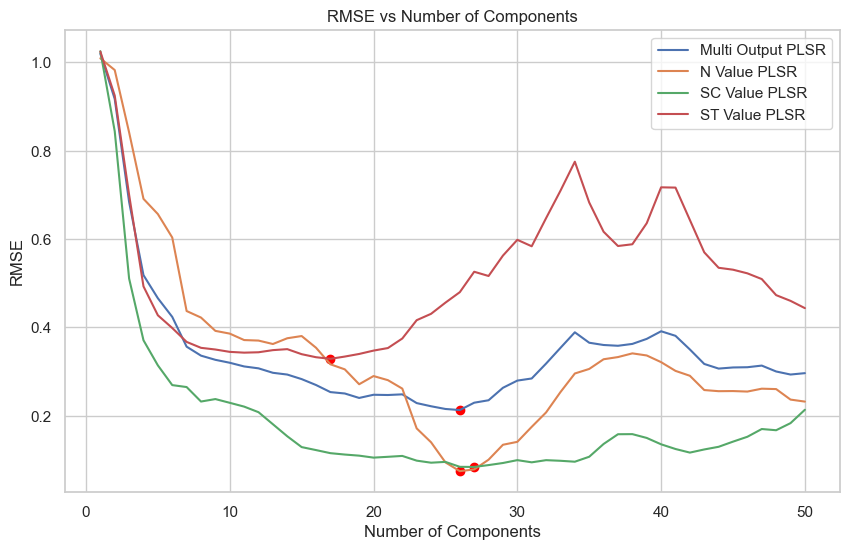

In [114]:
# Plot the RMSE vs Number of Components
plt.figure(figsize=(10, 6))

plt.plot([i for i in range(1,51)], [i[1] for i in multi_rmses['Avg_RMSE']], label = 'Multi Output PLSR')
plt.plot([i for i in range(1,51)], [i[1] for i in n_value_rmses['N_Value']], label = 'N Value PLSR')
plt.plot([i for i in range(1,51)], [i[1] for i in sc_value_rmses['SC_Value']], label = 'SC Value PLSR')
plt.plot([i for i in range(1,51)], [i[1] for i in st_value_rmses['ST_Value']], label = 'ST Value PLSR')

plt.scatter(best_n_components, multi_rmses['Avg_RMSE'][best_n_components-1][1], color = 'red')
plt.scatter(best_n_value_n_components, n_value_rmses['N_Value'][best_n_value_n_components-1][1], color = 'red')
plt.scatter(best_sc_value_n_components, sc_value_rmses['SC_Value'][best_sc_value_n_components-1][1], color = 'red')
plt.scatter(best_st_value_n_components, st_value_rmses['ST_Value'][best_st_value_n_components-1][1], color = 'red')

plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Components')
plt.legend()
plt.show()

# Training with CV10

In [115]:
from Training_and_Tuning import CV10

# Set the best number of components
multi_PLSR.model.estimator.set_params(n_components = best_n_components)
n_value_PLSR.model.set_params(n_components = best_n_value_n_components)
sc_value_PLSR.model.set_params(n_components = best_sc_value_n_components)
st_value_PLSR.model.set_params(n_components = best_st_value_n_components)

PLSRegression(n_components=17)

In [116]:
# Perform 10-fold cross validation
multi_rmse = CV10(multi_PLSR)
n_value_rmse = CV10(n_value_PLSR)
sc_value_rmse = CV10(sc_value_PLSR)
st_value_rmse = CV10(st_value_PLSR)

Cross Validation: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


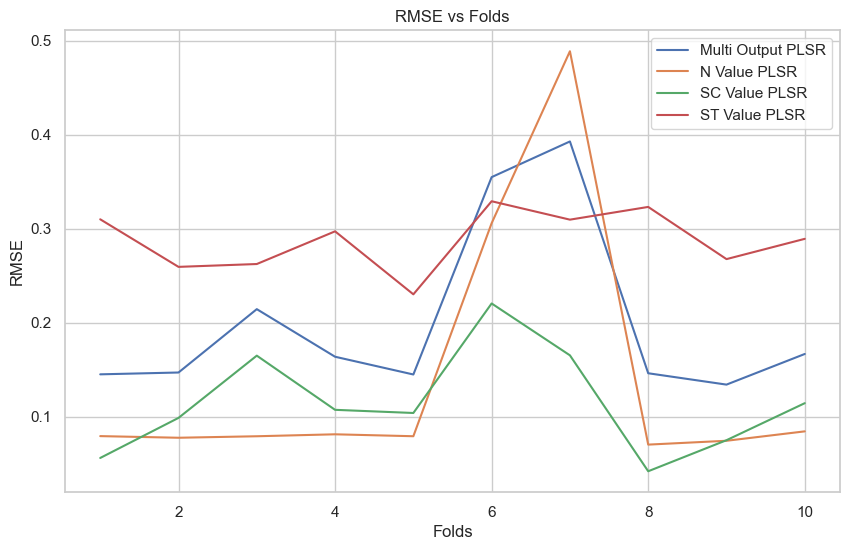

In [117]:
# Plot the rmse values for each model as a function of folds

plt.figure(figsize=(10, 6))

plt.plot([i for i in range(1,11)], multi_rmse['Avg_RMSE'], label = 'Multi Output PLSR')
plt.plot([i for i in range(1,11)], n_value_rmse['N_Value'], label = 'N Value PLSR')
plt.plot([i for i in range(1,11)], sc_value_rmse['SC_Value'], label = 'SC Value PLSR')
plt.plot([i for i in range(1,11)], st_value_rmse['ST_Value'], label = 'ST Value PLSR')

plt.xlabel('Folds')
plt.ylabel('RMSE')
plt.title('RMSE vs Folds')
plt.legend()
plt.show()


# Evaluation

In [126]:
# print RMSE results

n_value_test_rmse, sc_value_test_rmse, st_value_test_rmse = multi_PLSR.evaluate()
print(f' Multi Output PLSR RMSE: {np.mean([n_value_test_rmse, sc_value_test_rmse, st_value_test_rmse])}\n N Value PLSR RMSE: {n_value_test_rmse}\n SC Value PLSR RMSE: {sc_value_test_rmse}\n ST Value PLSR RMSE: {st_value_test_rmse}')

 Multi Output PLSR RMSE: 0.13577115406860188
 N Value PLSR RMSE: 0.07692214888840775
 SC Value PLSR RMSE: 0.058238931552764335
 ST Value PLSR RMSE: 0.2721523817646336


In [127]:
n_value_single_rmse = n_value_PLSR.evaluate()
sc_value_single_rmse = sc_value_PLSR.evaluate()
st_value_single_rmse = st_value_PLSR.evaluate()

print(f' N Value PLSR RMSE: {n_value_single_rmse}\n SC Value PLSR RMSE: {sc_value_single_rmse}\n ST Value PLSR RMSE: {st_value_single_rmse}')

 N Value PLSR RMSE: 0.07692214888840775
 SC Value PLSR RMSE: 0.05947138568662576
 ST Value PLSR RMSE: 0.26035931864937895


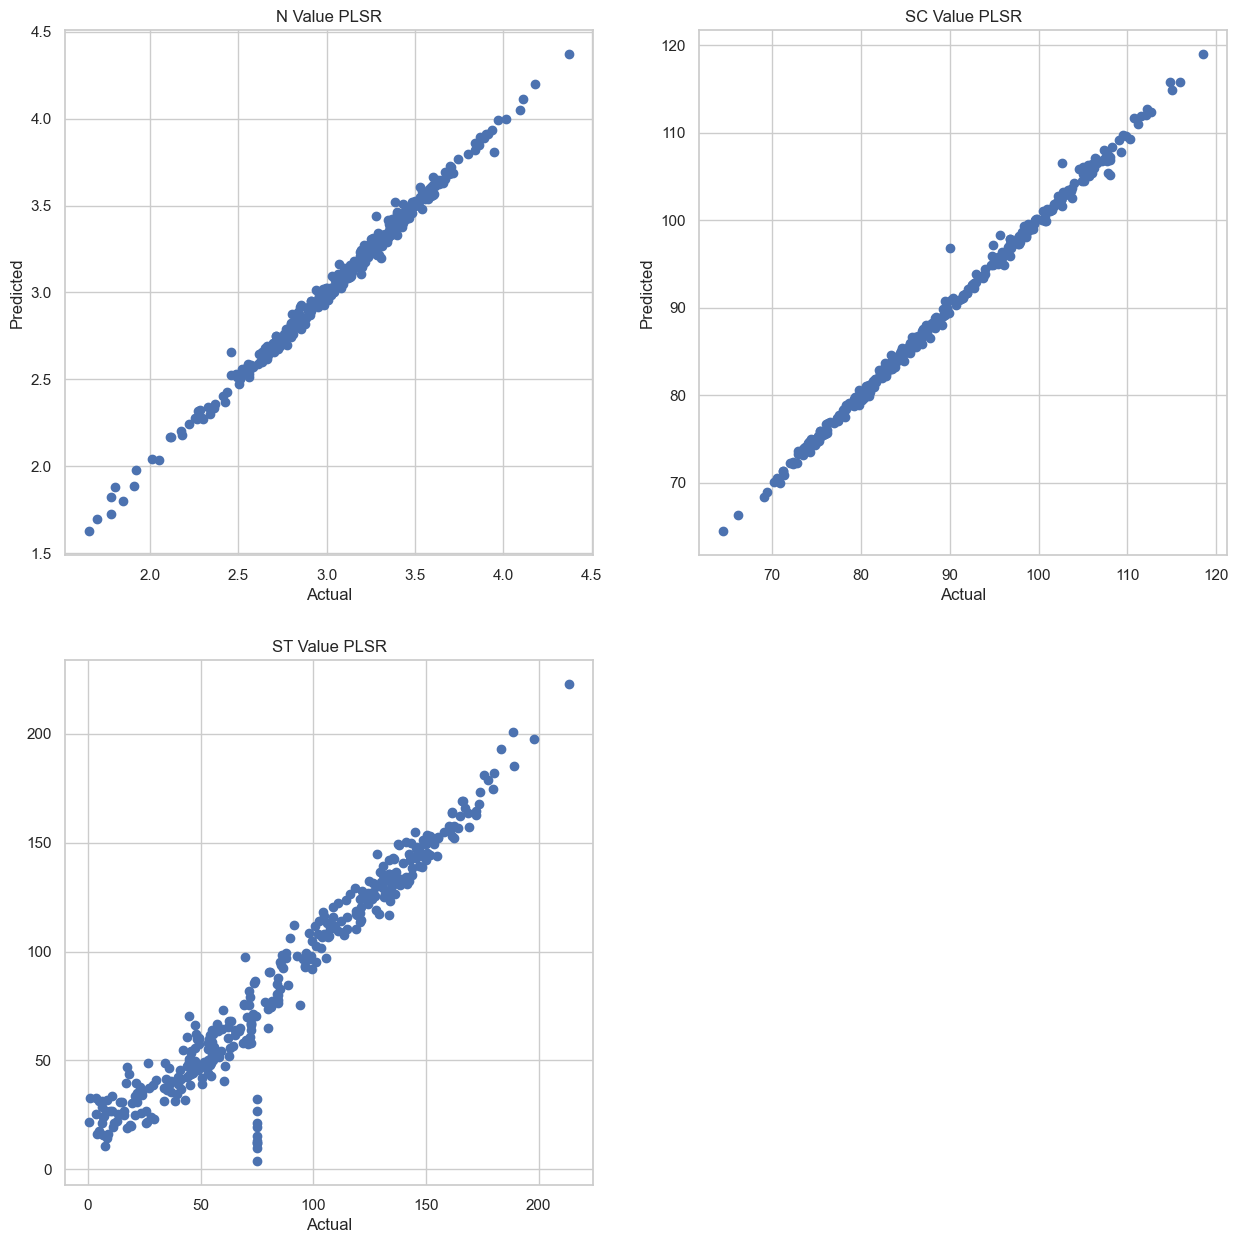

In [131]:
# Plot the predicted vs actual values for each model

y_hat = multi_PLSR.model.predict(dataset.X_test)
y_hat = Y_scaler.inverse_transform(y_hat)
y_test = Y_scaler.inverse_transform(dataset.Y_test)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0, 0].scatter(y_test[:,0], y_hat[:,0])
axs[0, 0].set_title('N Value PLSR')
axs[0, 0].set_xlabel('Actual')
axs[0, 0].set_ylabel('Predicted')

axs[0, 1].scatter(y_test[:,1], y_hat[:,1])
axs[0, 1].set_title('SC Value PLSR')
axs[0, 1].set_xlabel('Actual')
axs[0, 1].set_ylabel('Predicted')

axs[1, 0].scatter(y_test[:,2], y_hat[:,2])
axs[1, 0].set_title('ST Value PLSR')
axs[1, 0].set_xlabel('Actual')

# Disable last plot
axs[1, 1].axis('off')

plt.show()

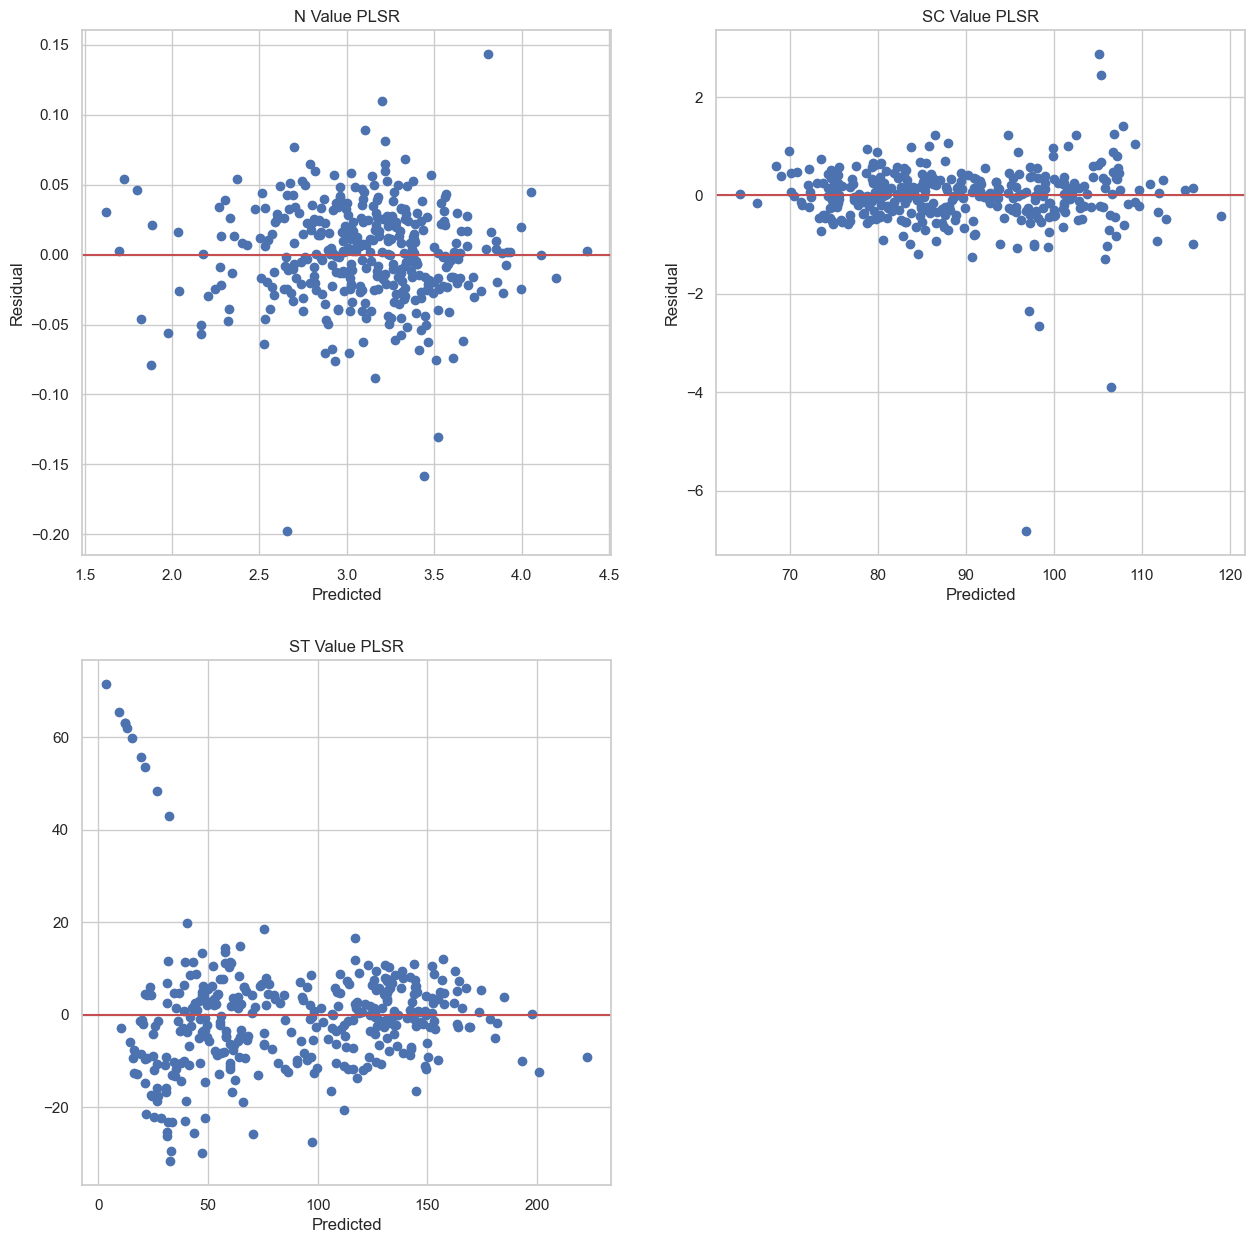

In [130]:
# Plot the residuals against the predicted values for the multi output PLSR model

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

residuals = y_test - y_hat

axs[0, 0].scatter(y_hat[:,0], residuals[:,0])
axs[0, 0].set_title('N Value PLSR')
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Residual')
axs[0, 0].axhline(y=0, color='r', linestyle='-')

axs[0, 1].scatter(y_hat[:,1], residuals[:,1])
axs[0, 1].set_title('SC Value PLSR')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('Residual')
axs[0, 1].axhline(y=0, color='r', linestyle='-')

axs[1, 0].scatter(y_hat[:,2], residuals[:,2])
axs[1, 0].set_title('ST Value PLSR')
axs[1, 0].set_xlabel('Predicted')
axs[1, 0].axhline(y=0, color='r', linestyle='-')

# Disable last plot
axs[1, 1].axis('off')

plt.show()